# Classification using CNN

## Overview of project

In this project, I'm going to build a CNN model to classify if an MRI scan shows a brain tumor or not. I will use the VGG-16 model to train the model. I could use VGG-19, but it's much too hardware intensive to be worth the increased accuracy. VGG-16 is the best model overall for image classification.

# Dataset

the dataset is the Brain MRI Images for Brain Tumor Detection, found at https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from sklearn.metrics import classification_report, confusion_matrix

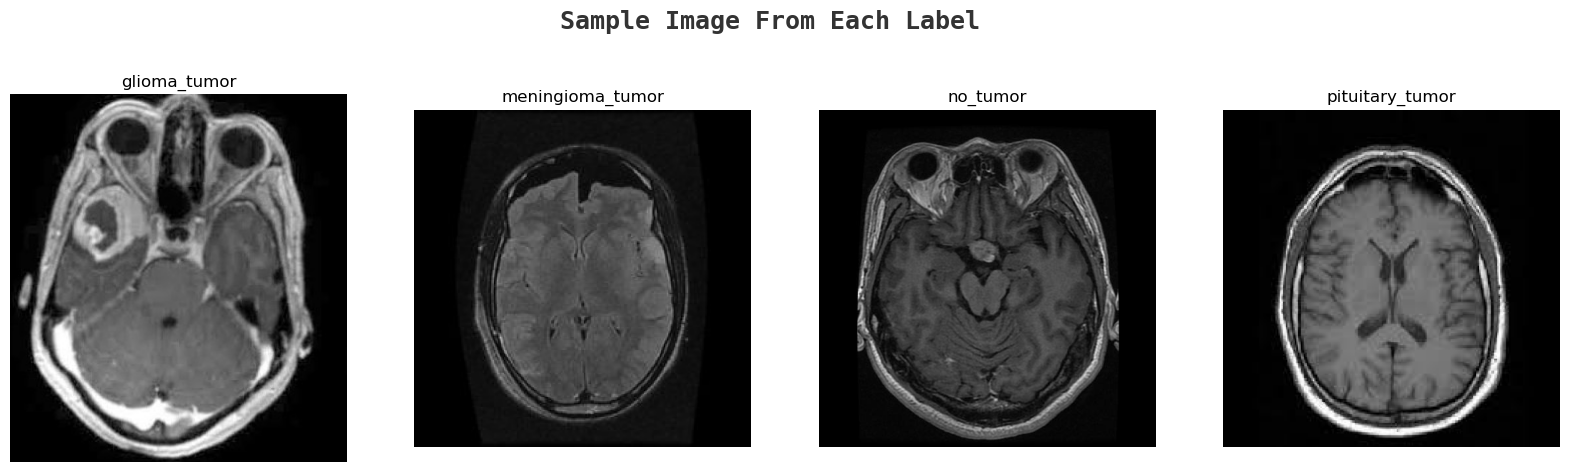

In [65]:
SEED = 420
np.random.seed(SEED)

path = 'tumor_types'
classes = os.listdir(path)
myclasses = classes
NUMCLASSES = len(myclasses)
myclasses

k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in myclasses:
    classnum = np.random.randint(NUMCLASSES)
    folder = path + '/' + myclasses[classnum]
    filelist = os.listdir(folder)
    i = np.random.randint(len(filelist))
    while filelist[i].lower()=='thumbs.db':
        i = np.random.randint(len(filelist))
    image_path = folder + '/' + filelist[i]
    image = cv2.imread(image_path)
    ax[k].imshow(image)
    ax[k].set_title(myclasses[k])
    ax[k].axis('off')
    k += 1

Now, creating the data generator for the images

In [66]:
train_datagen = ImageDataGenerator(
                                featurewise_center=False,
                                samplewise_center=True,
                                featurewise_std_normalization=False,
                                samplewise_std_normalization=True,
                                zca_epsilon=1e-06,
                                rotation_range=5,
                                width_shift_range=0.05,
                                height_shift_range=0.05,
                                brightness_range=None,
                                shear_range=0.5,
                                zoom_range=0.05,
                                channel_shift_range=0.0,
                                fill_mode="nearest",
                                cval=0.0,
                                horizontal_flip=False,
                                vertical_flip=False,
                                rescale=1./255,
                                preprocessing_function=None,#preprocess,
                                data_format=None,
                                validation_split=0.2,
                                dtype=None,
                            )

In [67]:
# Make a dtaframe with all the file paths and labels
allfilelist = []
alllabels = []
alllabels_word = []
for i in range(NUMCLASSES):
    filepath = path + '/' + myclasses[i]
    filelist = os.listdir(filepath)
    for f in filelist:
        if f.lower() == 'thumbs.db':
            continue
        
        fullpath = filepath + '/' + f
        allfilelist.append(fullpath)
        alllabels.append(i)
        alllabels_word.append(myclasses[i])
        
d = {'filename':allfilelist,'labelnum':alllabels,'label':alllabels_word}

df = pd.DataFrame(d)
df.tail()

,filename,labelnum,label
3155,tumor_types/pituitary_tumor/p (95).jpg,3,pituitary_tumor
3156,tumor_types/pituitary_tumor/p (96).jpg,3,pituitary_tumor
3157,tumor_types/pituitary_tumor/p (97).jpg,3,pituitary_tumor
3158,tumor_types/pituitary_tumor/p (98).jpg,3,pituitary_tumor
3159,tumor_types/pituitary_tumor/p (99).jpg,3,pituitary_tumor


In [68]:
df = df.sample(frac=1.0)
df.head()

,filename,labelnum,label
1155,tumor_types/meningioma_tumor/m (21).jpg,1,meningioma_tumor
1708,tumor_types/meningioma_tumor/m3 (182).jpg,1,meningioma_tumor
390,tumor_types/glioma_tumor/gg (450).jpg,0,glioma_tumor
92,tumor_types/glioma_tumor/gg (182).jpg,0,glioma_tumor
385,tumor_types/glioma_tumor/gg (446).jpg,0,glioma_tumor


In [69]:
print(df['label'].value_counts())

meningioma_tumor    937
glioma_tumor        926
pituitary_tumor     901
no_tumor            396
Name: label, dtype: int64


In [70]:
INPUT_SIZE = 255
BATCH_SIZE = 16

training_set = train_datagen.flow_from_dataframe(
                                            dataframe=df,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            #weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='training',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                        )

validation_set = train_datagen.flow_from_dataframe( dataframe=df,
                                            directory='',
                                            x_col="filename",
                                            y_col="label",
                                            #weight_col=None,
                                            target_size=(INPUT_SIZE, INPUT_SIZE),
                                            color_mode="rgb",
                                            classes=None,
                                            class_mode="categorical",
                                            batch_size=BATCH_SIZE,
                                            shuffle=True,
                                            seed=None,
                                            save_to_dir=None,
                                            save_prefix="",
                                            save_format="png",
                                            subset='validation',
                                            interpolation="nearest",
                                            #validate_filenames=True
                                            )


Found 2528 validated image filenames belonging to 4 classes.
Found 632 validated image filenames belonging to 4 classes.


In [71]:
from tensorflow.keras.applications import VGG16


#Load the VGG model
vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=(INPUT_SIZE, INPUT_SIZE, 3))

# Freeze the layers except the last 4 layers
for layer in vgg_conv.layers[:-4]:
    layer.trainable = False

# Check the trainable status of the individual layers
for layer in vgg_conv.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x000002151F039BA0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002152C5DF370> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002152B5A2F20> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002152C5F3670> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x0000021522E75C00> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002152C5F24D0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002152C5F3A00> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002152C5F1F90> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002152C69CA90> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002152C69E320> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x000002152C69F640> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x000002152C69F280> False
<keras.layers.convolutional.conv2d.Conv2D object

In [72]:
vgg_conv.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 255, 255, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 255, 255, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 255, 255, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 127, 127, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 127, 127, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 127, 127, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 63, 63, 128)       0     

In [73]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# Create the model
model = models.Sequential()

# Add the vgg convolutional base model
model.add(vgg_conv)
 
# Add new layers
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUMCLASSES, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_4 (Dense)             (None, 1024)              25691136  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 4)                 4100      
                                                                 
Total params: 40,409,924
Trainable params: 32,774,660
Non-trainable params: 7,635,264
_________________________________________________________________


In [74]:
#Training

model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
num_epochs = 12
history = model.fit(training_set, steps_per_epoch=len(training_set), epochs=num_epochs, validation_data=validation_set,
                   validation_steps = len(validation_set))

model.save_weights("model-normalized-aug-vgg.h5")
print("Saved model to disk after",num_epochs,"epochs.")
# model.load_weights('model-normalized-aug.h5')

C:\Users\Ethan\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\rmsprop.py:140: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/12
158/158 [==============================] - 70s 418ms/step - loss: 0.7256 - acc: 0.7322 - val_loss: 0.5088 - val_acc: 0.8228
Epoch 2/12
158/158 [==============================] - 56s 355ms/step - loss: 0.3628 - acc: 0.8797 - val_loss: 0.3363 - val_acc: 0.8623
Epoch 3/12
158/158 [==============================] - 57s 362ms/step - loss: 0.2496 - acc: 0.9205 - val_loss: 0.2359 - val_acc: 0.9177
Epoch 4/12
158/158 [==============================] - 58s 365ms/step - loss: 0.2019 - acc: 0.9395 - val_loss: 0.3045 - val_acc: 0.8908
Epoch 5/12
158/158 [==============================] - 56s 356ms/step - loss: 0.1751 - acc: 0.9498 - val_loss: 0.2173 - val_acc: 0.9193
Epoch 6/12
158/158 [==============================] - 56s 354ms/step - loss: 0.1536 - acc: 0.9644 - val_loss: 0.2410 - val_acc: 0.9494
Epoch 7/12
158/158 [==============================] - 56s 354ms/step - loss: 0.1339 - acc: 0.9648 - val_loss: 0.2163 - val_acc: 0.9415
Epoch 8/12
158/158 [==============================] - 6

In [75]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

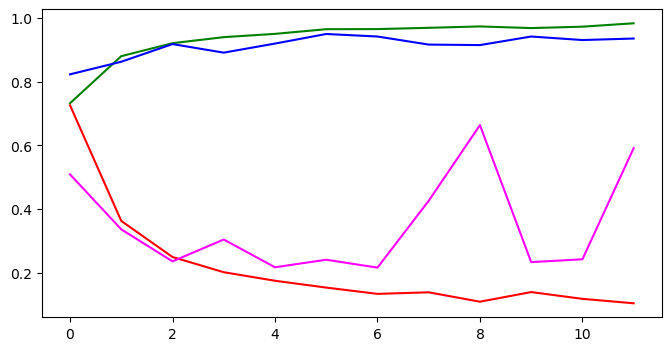

In [76]:
fig = plt.figure(figsize=(8,4))
plt.plot(history.history['loss'],color='red')
plt.plot(history.history['acc'],color='green')
plt.plot(history.history['val_loss'],color='magenta')
plt.plot(history.history['val_acc'],color='blue')
plt.show()

showing the increase in accurary and decrease in loss, you can see I'm getting deminishing returns after the 6th Epoch

1/1 [==============================] - 1s 609ms/step
Actual Class: pituitary_tumor
Predictions:
no_tumor : 0.9874807
pituitary_tumor : 0.012512741
meningioma_tumor : 5.6306844e-06
glioma_tumor : 9.86655e-07


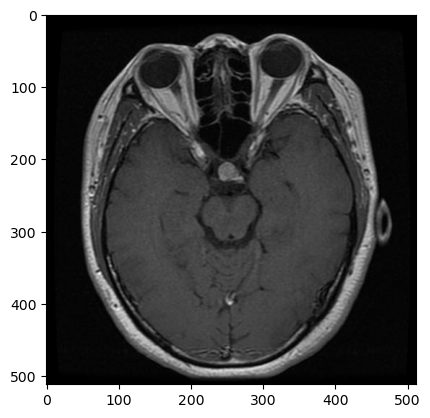

In [77]:
# Get random image
classnum = np.random.randint(NUMCLASSES)
folder = path + '/' + myclasses[classnum]
filelist = os.listdir(folder)
i = np.random.randint(len(filelist))
while filelist[i].lower()=='thumbs.db':
    i = np.random.randint(len(filelist))
image_path = folder + '/' + filelist[i]
image = cv2.imread(image_path)
plt.imshow(image)

# Prepare image
img = tf.keras.preprocessing.image.load_img(image_path)
img = tf.keras.preprocessing.image.img_to_array(img)
#img = preprocess(img)
img = cv2.resize(img,(INPUT_SIZE,INPUT_SIZE))
img_tensor = np.expand_dims(img, axis=0)
img_tensor /= 255.

# Print what the top predicted class is
#print(img_tensor.shape)
preds = model.predict(img_tensor,steps=1)
preds = preds.flatten()
#print("Output Probabilities:", preds)
order = np.argsort(preds)
order = order[::-1]
print('Actual Class:',myclasses[classnum])
print('Predictions:')
for i in range(4):
    if preds[order[i]] == 0:
        break
    else:
        print(myclasses[order[i]], ':', preds[order[i]])


pulling one of the images from the dataset and showing the prediction probabilities

40/40 [==============================] - 11s 279ms/step


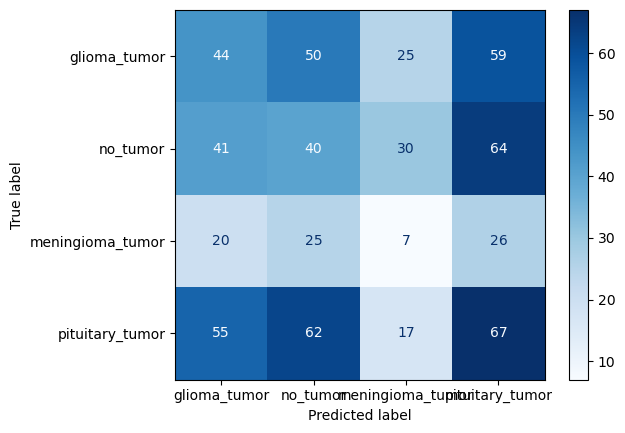

In [86]:
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

#Confution Matrix and Classification Report
Y_pred = model.predict(validation_set, len(validation_set))
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(validation_set.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

for some reason the confusion matrix doesn't reflect the accuracy of the model

In [85]:
preds

array([9.8665498e-07, 5.6306844e-06, 9.8748070e-01, 1.2512741e-02],
      dtype=float32)

In [81]:
validation_set